In [1]:
import sys
sys.path.append('/home/brain3/Desktop/Pose-Estimation-for-Sensor-Calibration')

import cv2
import numpy as np
import os
import glob
# import pickle

# import rospy
from ur_msgs.srv import JointTrajectory, EndPose, JointStates

from matplotlib import pyplot as plt
from utils_realsense import RealSenseSensor

from realrobot_utils import *

# from calibration_helper import *
# from custom_geometric_transform import *
# from transformations import quaternion_matrix
# from transformations import quaternion_from_matrix
# from transformations import rotation_matrix

# from helpers import Tools
# EPS=0.00001
from Pose_Estimation_Class import *

In [2]:
realsense = RealSenseSensor("025222072234")
K_rs = realsense._color_intrinsics
D_rs = 0

In [3]:
planUR5 = rospy.ServiceProxy('plan_robot_arm', JointTrajectory)
moveUR5 = rospy.ServiceProxy('move_robot_arm', JointTrajectory)
getEEFPose = rospy.ServiceProxy('get_eef_pose', EndPose)
getJointStates = rospy.ServiceProxy('get_joint_states', JointStates)

In [4]:
rospy.wait_for_service('plan_robot_arm')
rospy.wait_for_service('move_robot_arm')
rospy.wait_for_service('get_eef_pose')
rospy.wait_for_service('get_joint_states')

In [5]:
ROBOT_INIT_POS = [0.0, -0.3, 0.65]

In [6]:
def get_joint_states():
    joints_Str = getJointStates().joint_states.replace('(', '').replace(')', '').split(', ')
    joints = [float(j) for j in joints_Str]
    return joints

In [7]:
def get_eef_pose():
    pose = getEEFPose().eef_pose
    position = [pose.position.x, pose.position.y, pose.position.z]
    quaternion = [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]
    return position, quaternion

In [8]:
def get_view(goal_pos=None, quat=[-1, 0, 0, 0], show_img=False):
    ARM_JOINT_NAME = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
    if goal_pos is not None:
        plans = moveUR5(ARM_JOINT_NAME, None, goal_pos, quat)
    rospy.sleep(0.5)
    color, depth = realsense.frames(spatial=True, hole_filling=True, temporal=True)
    if show_img:
        plt.imshow(color)
        plt.show()
    return color, depth

In [9]:
CHECKERBOARD = (6, 9)
def get_cam_theta_p(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    return R_vec_cam_to_chess, p_cam_to_chess

def get_cam_R_T(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    R_cam_to_chess, _ = cv2.Rodrigues(R_vec_cam_to_chess)
    T_cam_to_chess = form_T(R_cam_to_chess, p_cam_to_chess)
    return R_cam_to_chess, T_cam_to_chess

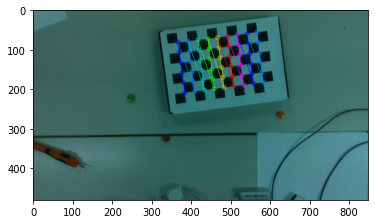

[[-0.13310493 -0.98914561 -0.06224184 -0.0717112 ]
 [ 0.99070274 -0.13457098  0.01996848 -0.07897756]
 [-0.02812767 -0.05900526  0.99786132 -0.60437127]
 [ 0.          0.          0.          1.        ]]


In [10]:
img, _ = get_view(ROBOT_INIT_POS)
R, T = get_cam_R_T(img)
print(np.linalg.inv(T))

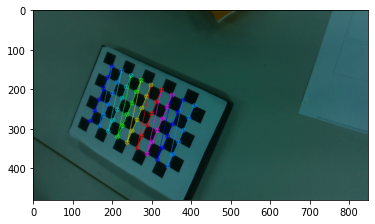

[-0.249, -0.528, 0.45]
[0.9646, 0.2047, 0.1661, -0.0022]


In [18]:
img, _ = get_view(None)
get_cam_R_T(img)
pos, quat = get_eef_pose()
print([np.round(p, 3) for p in pos])
print([np.round(q, 4) for q in quat])

In [20]:
calib_positions = np.array([
    [0.0, -0.3, 0.65],
    [0.282, -0.413, 0.606],
    [0.249, -0.217, 0.567],
    [-0.193, -0.278, 0.495],
    [-0.249, -0.528, 0.45]
])
calib_quaternions = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.9634, 0.2052, -0.1588, -0.067],
    [0.9626, 0.1529, -0.205, 0.09],
    [0.9697, -0.1399, 0.191, 0.0606],
    [0.9646, 0.2047, 0.1661, -0.0022]
])

calib_positions = np.array([
        [0.0, -0.3, 0.65],
        [0.0, -0.49, 0.59],
        [0.25, -0.41, 0.61],
        [0.26, -0.19, 0.61],
        [-0.09, -0.39, 0.58]
    ])
calib_quaternions = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.990, 0.004, 0.004, -0.139],
        [0.994, 0.005, -0.112, -0.014],
        [0.976, 0.028, -0.109, 0.187],
        [0.994, 0.068, 0.083, 0.002]
    ])

In [21]:
T_realsense = []
T_ur5 = []

for p, q in zip(calib_positions, calib_quaternions):
    img, _ = get_view(p, q)
    R, T_cam_to_chess = get_cam_R_T(img)
    
    T_base_to_eef = form_T(quaternion_matrix(q)[:3, :3], p)
    
    T_realsense.append(T_cam_to_chess)
    T_ur5.append(T_base_to_eef)

img, _ = get_view(ROBOT_INIT_POS)

In [22]:
T_ur5

[array([[ 1.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  1.  ,  0.  , -0.3 ],
        [ 0.  ,  0.  ,  1.  ,  0.65],
        [ 0.  ,  0.  ,  0.  ,  1.  ]]),
 array([[ 0.94058433,  0.06392708, -0.3334883 ,  0.282     ],
        [-0.19427624,  0.90680354, -0.37411773, -0.413     ],
        [ 0.27849212,  0.41667813,  0.86534472,  0.606     ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.89976024, -0.23593289, -0.36710649,  0.249     ],
        [ 0.1105677 ,  0.93704961, -0.33122924, -0.217     ],
        [ 0.42214487,  0.25743678,  0.86920654,  0.567     ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.91969677, -0.17096201,  0.35345416, -0.193     ],
        [ 0.06408305,  0.95351328,  0.29445846, -0.278     ],
        [-0.38736445, -0.24816207,  0.88789885,  0.495     ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.9448091 ,  0.07224924,  0.31955564, -0.249     ],
        [ 0.06376033,  0.91618189,

In [23]:
T_realsense

[array([[-0.13304513,  0.99071876, -0.02784492,  0.051689  ],
        [-0.98926454, -0.13445864, -0.05724107, -0.11716603],
        [-0.06045379,  0.01993035,  0.997972  ,  0.60022861],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.30108858,  0.90615854, -0.29702251,  0.16200276],
        [-0.94693056,  0.24734717, -0.20528488,  0.00948591],
        [-0.11255297,  0.34306863,  0.93254262,  0.62474389],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.14018052,  0.88163949, -0.45062315,  0.10696196],
        [-0.97238012,  0.2083641 ,  0.10517273, -0.02784949],
        [ 0.18661812,  0.42343383,  0.8864973 ,  0.63509341],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.37459105,  0.85220822,  0.36527071,  0.0054553 ],
        [-0.91150581, -0.4106285 ,  0.02326786, -0.05539414],
        [ 0.16981963, -0.32423044,  0.93061051,  0.49696298],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),


In [24]:
# form A, B matrix
A = []
B = []
for i, Ti in enumerate(T_realsense):
    for Tj in T_realsense[i+1:]:
        A.append(Ti.dot(np.linalg.inv(Tj)))

for i, Ti in enumerate(T_ur5):
    for Tj in T_ur5[i+1:]:
        B.append(np.linalg.inv(Ti).dot(Tj))

A = np.array(A).transpose([1,2,0])
B = np.array(B).transpose([1,2,0])

+ Simultaneous Robot/World and Tool/Flange Calibration:    
Implementation of Shah, Mili. "Solving the robot-world/hand-eye calibration problem using the Kronecker product." 
Journal of Mechanisms and Robotics 5.3 (2013): 031007.

Batch_Processing solvesfor  X and Y in AX=YB from a set of (A,B) paired measurements.
(Ai,Bi) are absolute pose measurements with known correspondance       
A: (4x4xn) 
X: (4x4): unknown
Y: (4x4): unknown
B: (4x4xn) 
n number of measurements

+ EKF,IEKF solves for AX=XB from a set of (Ai,Bi) relative pose measurements with known correspondance.
so3 representation was used to represent the state of rotation.  

In [44]:
def get_error(T_rs_to_eef):
    error = 0
    for i in range(A.shape[-1]):
        err = np.linalg.norm(A[:,:,i].dot(T_rs_to_eef) - T_rs_to_eef.dot(B[:,:,i]))
        error += err
    return error

In [45]:
#IEKF
iekf=IEKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    iekf.Update(AA,BB)
    
theta=np.linalg.norm(iekf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=iekf.x[0:3]/np.linalg.norm(iekf.x[:3])
euler_iekf=Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('IEKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_iekf)*180/np.pi)
print('Translation:', iekf.x[3:])
print('------------------------------')
T_rs_to_eef = form_T(Tools.vec2rotmat(theta, k), iekf.x[3:])
print(T_rs_to_eef)

print('Error:', get_error(T_rs_to_eef))

IEKF Results
Euler: [ 143.89238278   87.69441483 -150.16139776]
Translation: [0.26784562 0.04311645 0.29136707]
------------------------------
[[-0.03250163 -0.02370722  0.99919048  0.26784562]
 [-0.10952218  0.99378279  0.02001638  0.04311645]
 [-0.99345283 -0.10878296 -0.03489603  0.29136707]
 [ 0.          0.          0.          1.        ]]
Error: 12.658455236864269


In [29]:
A[:,:,1].dot(T_rs_to_eef)

array([[-0.01247405,  0.25615082,  0.96655634,  0.01039982],
       [ 0.23569979,  0.94014652, -0.24610999,  0.01527356],
       [-0.97174586,  0.22474713, -0.07210213,  0.436961  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [30]:
T_rs_to_eef.dot(B[:,:,1])

array([[ 0.70734822,  0.06458404,  0.70390866,  0.11798949],
       [ 0.19061155,  0.94150106, -0.27792623,  0.14255509],
       [-0.68068035,  0.33076375,  0.65365863,  0.17657767],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [53]:
np.linalg.norm(A[:,:,0][:3,3])

0.3110954056466676

In [54]:
np.linalg.norm(B[:,:,0][:3,3])

0.30696742498187

In [55]:
A[:,:,0]

array([[ 0.86596046,  0.37675212,  0.32889258, -0.29764644],
       [-0.40269522,  0.91525759,  0.01183638, -0.06800505],
       [-0.29656204, -0.14269331,  0.94429316,  0.05968468],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [51]:
B[:,:,0]

array([[ 0.94058433,  0.06392708, -0.3334883 ,  0.282     ],
       [-0.19427624,  0.90680354, -0.37411773, -0.113     ],
       [ 0.27849212,  0.41667813,  0.86534472, -0.044     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [46]:
#UKF
ukf = UKF()
for i in range(len(A[1,1,:])):
    AA = A[:,:,i] 
    BB = B[:,:,i]
    ukf.Update(AA,BB)
    
theta = np.linalg.norm(ukf.x[:3])
if theta < EPS:
    k = [0,1,0] #VRML standard
else:
    k = ukf.x[0:3]/np.linalg.norm(ukf.x[:3])
euler_ukf = Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('UKF Results')
print('Euler:', np.array(euler_ukf)*180/np.pi)
print('Translation:', ukf.x[3:])
print('------------------------------')
T_rs_to_eef = form_T(Tools.vec2rotmat(theta, k), ukf.x[3:])
print(T_rs_to_eef)
print('Error:', get_error(T_rs_to_eef))

UKF Results
Euler: [ 14.58895307  67.98285854 -12.51998358]
Translation: [0.11243745 0.05388578 0.43712695]
------------------------------
[[ 0.36279687 -0.09442681  0.92707174  0.11243745]
 [ 0.05140215  0.99536598  0.08126739  0.05388578]
 [-0.93044949  0.01816993  0.3659694   0.43712695]
 [ 0.          0.          0.          1.        ]]
Error: 12.839901916301486


<IPython.core.display.Javascript object>


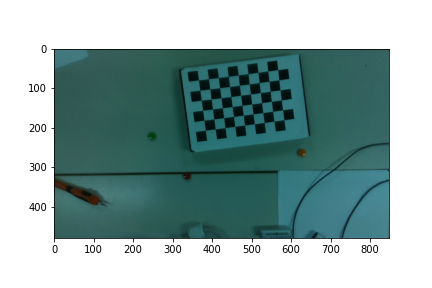

In [33]:
%matplotlib notebook
color, depth = get_view(ROBOT_INIT_POS, show_img=True)

In [36]:
goal_pixel = np.array([420, 240])
p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
print(p_rs_to_goal)

[-0.00304435 -0.01086758  0.61800003]


In [35]:
goal_pixel = np.array([340, 326])
p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
print(p_rs_to_goal)

[-0.08796979  0.07996472  0.64200002]


In [34]:
goal_pixel = np.array([629, 266])
p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
print(p_rs_to_goal)

[0.22043735 0.01645123 0.648     ]


array([-0.00304435, -0.01086758,  0.61800003,  1.        ])

In [41]:
goal_pixel = np.array([420, 240])
p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
print(p_rs_to_goal)

T_base_to_initeef = form_T(np.eye(3), ROBOT_INIT_POS)
T_eef_to_rs = np.linalg.inv(T_rs_to_eef)
# T_eef_to_rs = np.linalg.inv(form_T(np.eye(3), T_rs_to_eef[:3, 3]))
# T_rs_to_goal = np.linalg.inv(form_T(np.eye(3), p_rs_to_goal))

goal_position = T_base_to_initeef.dot(T_eef_to_rs.dot(np.concatenate([p_rs_to_goal, [1]])))[:3]
print(goal_position)

[-0.00304435 -0.01086758  0.61800003]
[-0.30977763 -0.38275845  0.36685056]


In [58]:
def move_to_pixel(color, goal_pixel):
    color[goal_pixel[1], goal_pixel[0]] = [255,0,0]
    plt.imshow(color)
    plt.show()

    p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
    print(p_rs_to_goal)
    
    T_base_to_initeef = form_T(np.eye(3), ROBOT_INIT_POS)
    T_eef_to_rs = np.linalg.inv(T_rs_to_eef)
    # T_eef_to_rs = np.linalg.inv(form_T(np.eye(3), T_rs_to_eef[:3, 3]))
    T_rs_to_goal = np.linalg.inv(form_T(np.eye(3), p_rs_to_goal))

    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))
    # T_base_to_goal = T_base_to_initeef.dot(T_rs_to_goal)
    
    
    goal_position = T_base_to_goal[:3, 3] + np.array([0, 0, 0.2])
    print(goal_position)
#     _ = get_view(goal_position)

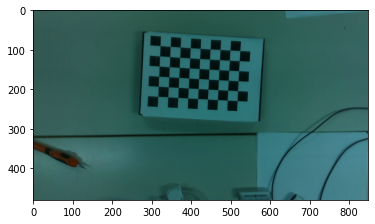

[-0.00301479 -0.01076207  0.61200005]
[ 0.53296257 -0.27247523  0.56998658]


In [59]:
goal_pixel = np.array([420, 240])
move_to_pixel(color, goal_pixel)

In [54]:
color.shape

(480, 848, 3)

In [60]:
T_eef_to_rs = np.linalg.inv(T_rs_to_eef)

In [62]:
p_rs_to_goal

array([-0.00301479, -0.01076207,  0.61200005])

In [64]:
T_base_to_initeef = form_T(np.eye(3), ROBOT_INIT_POS)

In [70]:
T_base_to_initeef.dot(T_eef_to_rs)

array([[ 0.48093294, -0.02190077, -0.87648381, -0.00465978],
       [ 0.02277879,  0.99966263, -0.01247976, -0.29093995],
       [ 0.87646143, -0.01396332,  0.48126956,  0.6620315 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [71]:
T_base_to_initeef.dot(T_eef_to_rs.dot(np.linalg.inv(T_rs_to_goal)))

array([[ 0.48093294, -0.02190077, -0.87648381,  0.53296257],
       [ 0.02277879,  0.99966263, -0.01247976, -0.27247523],
       [ 0.87646143, -0.01396332,  0.48126956,  0.36998658],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [68]:
T_base_to_initeef = form_T(np.eye(3), ROBOT_INIT_POS)
T_eef_to_rs = np.linalg.inv(T_rs_to_eef)
# T_eef_to_rs = np.linalg.inv(form_T(np.eye(3), T_rs_to_eef[:3, 3]))
# T_rs_to_goal = np.linalg.inv(form_T(np.eye(3), p_rs_to_goal))
T_rs_to_goal = form_T(np.eye(3), p_rs_to_goal)

T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))
# T_base_to_goal = T_base_to_initeef.dot(T_rs_to_goal)

In [49]:
T_base_to_goal[:3, 3] + np.array([0, 0, 0.2])

array([ 15.68720214,   4.85535939, -62.65894225])

In [34]:
T_base_to_goal[:3, 3] + np.array([0, 0, 0.2])

array([-0.01722437, -0.28922035,  0.23699996])

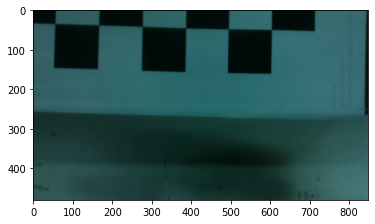

In [41]:
_ = get_view(T_base_to_goal[:3, 3] + np.array([0, 0, 0.2]))

In [ ]:
def move_to_pixel(center_x, center_y):
    pixel = np.array([center_x, center_y], np.int32)
    grasp_depth = 0.70
    psi = 0.0
    midx, midy = realsense._intrinsics[:2,2]
    raw_pixel = inverse_raw_pixel(pixel, midx, midy, cs=430)
    
    endpoint_pose_base = baxter_right_arm._limb.endpoint_pose()
    T_base_to_endpoint = get_transformation_from_pose(endpoint_pose_base)
    T_endpoint_to_realsense = np.linalg.inv(T_realsense_to_endpoint)
    
    K_realsense, D_realsense = realsense.get_realsense_camera_K_and_D()
    bin_input_rgb_im, bin_input_depth_im, _, _, bin_depth_im, _= get_input_rgbd_image(realsense, crop_size = 430, resize_width = 256, resize_height = 256)
    
    diff_endpoint_position_realsense = inverse_projection(bin_depth_im, raw_pixel, K_realsense, D_realsense)
    diff_endpoint_position_realsense[2] = grasp_depth
    diff_endpoint_quaternion_realsense = quaternion_from_matrix(T_realsense_to_endpoint.dot(rotation_matrix(psi, [0.,0.,1.])))
    
    T_realsense_to_new_endpoint = form_T(quaternion_matrix(diff_endpoint_quaternion_realsense)[:3,:3], diff_endpoint_position_realsense)
    T_base_to_new_endpoint =T_base_to_endpoint.dot(T_endpoint_to_realsense.dot(T_realsense_to_new_endpoint))
    goal_eef_position = T_base_to_new_endpoint[:3,3]
    goal_eef_quaternion = quaternion_from_matrix(T_base_to_new_endpoint)
    goal_eef_jointangles = baxter_right_arm.move_to_pose(goal_eef_position+[0.0, 0.0, 0.05], goal_eef_quaternion, timeout=10.0)
    goal_eef_jointangles = baxter_right_arm.move_to_pose(goal_eef_position, goal_eef_quaternion, timeout=10.0)
    
    return goal_eef_position